In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.metrics import r2_score,mean_absolute_error

train_df = pd.read_csv('../data/CDC_train.csv')
test_df = pd.read_csv('../data/CDC_test.csv')

In [2]:
null_counts = pd.concat([train_df.isnull().sum(), test_df.isnull().sum()], axis=1)
null_counts.columns = ['Train Nulls', 'Test Nulls']
null_counts

Train Nulls  Test Nulls
id                       0         0.0
date                     0         0.0
price                    0         NaN
bedrooms                 0         0.0
bathrooms                0         0.0
sqft_living              0         0.0
sqft_lot                 0         0.0
floors                   0         0.0
waterfront               0         0.0
view                     0         0.0
condition                0         0.0
grade                    0         0.0
sqft_above               0         0.0
sqft_basement            0         0.0
yr_built                 0         0.0
yr_renovated             0         0.0
zipcode                  0         0.0
lat                      0         0.0
long                     0         0.0
sqft_living15            0         0.0
sqft_lot15               0         0.0

no missing values

In [3]:
train_df['date']=pd.to_datetime(train_df['date'])
train_df['sale_yr']=train_df['date'].dt.year
train_df['sale_month']=train_df['date'].dt.month
print(train_df.columns.tolist())
before_count=len(train_df)
print("total number of rows in tabular dataset is :",before_count)

['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_yr', 'sale_month']
total number of rows in tabular dataset is : 16209


In [4]:
# remove rows where the image failed to download
print("\nChecking for matching images...")

import os
from tqdm import tqdm

valid_rows = []
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = os.path.join(r'D:\CDC OPEN PROJECT\notebook\house_images_dataset\zoom_18', f"{row['id']}.jpg")

    if os.path.exists(img_path) and os.path.getsize(img_path) > 0:
        valid_rows.append(idx)

df_clean = train_df.loc[valid_rows].copy()
print(f"Rows with valid images: {len(df_clean)} (Dropped {len(train_df) - len(df_clean)} rows)")


Checking for matching images...


  0%|          | 0/16209 [00:00<?, ?it/s]

100%|██████████| 16209/16209 [00:02<00:00, 7659.39it/s]

Rows with valid images: 16155 (Dropped 54 rows)


In [5]:
id_counts = train_df['id'].value_counts()
duplicate_ids = id_counts[id_counts > 1]

print(f"Total duplicate IDs found: {len(duplicate_ids)}")
print("-" * 30)
print("Top 10 IDs with multiple rows:")
print(duplicate_ids.head(10))

example_id = duplicate_ids.index[0]
print(f"\nShowing all data for ID: {example_id}")
display(train_df[train_df['id'] == example_id])

Total duplicate IDs found: 99
------------------------------
Top 10 IDs with multiple rows:
id
3935900232    2
4302201085    2
1524079093    2
643300040     2
526059224     2
6791200120    2
8651510380    2
9136103130    2
7167000040    2
2023049218    2
Name: count, dtype: int64

Showing all data for ID: 3935900232


id       date   price  bedrooms  bathrooms  sqft_living  \
6577   3935900232 2015-01-12  237000         3        1.0          920   
10337  3935900232 2014-09-29  207000         3        1.0          920   

       sqft_lot  floors  waterfront  view  ...  sqft_basement  yr_built  \
6577       5546     1.0           0     0  ...              0      1928   
10337      5546     1.0           0     0  ...              0      1928   

       yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
6577              0    98125  47.7114 -122.284           1300        5546   
10337             0    98125  47.7114 -122.284           1300        5546   

       sale_yr  sale_month  
6577      2015           1  
10337     2014           9  

[2 rows x 23 columns]

Out of 16,209 total records, I matched 16,155 rows to images by accounting for 99 duplicate house IDs, leaving a minor gap of 54 unique properties without visual data.

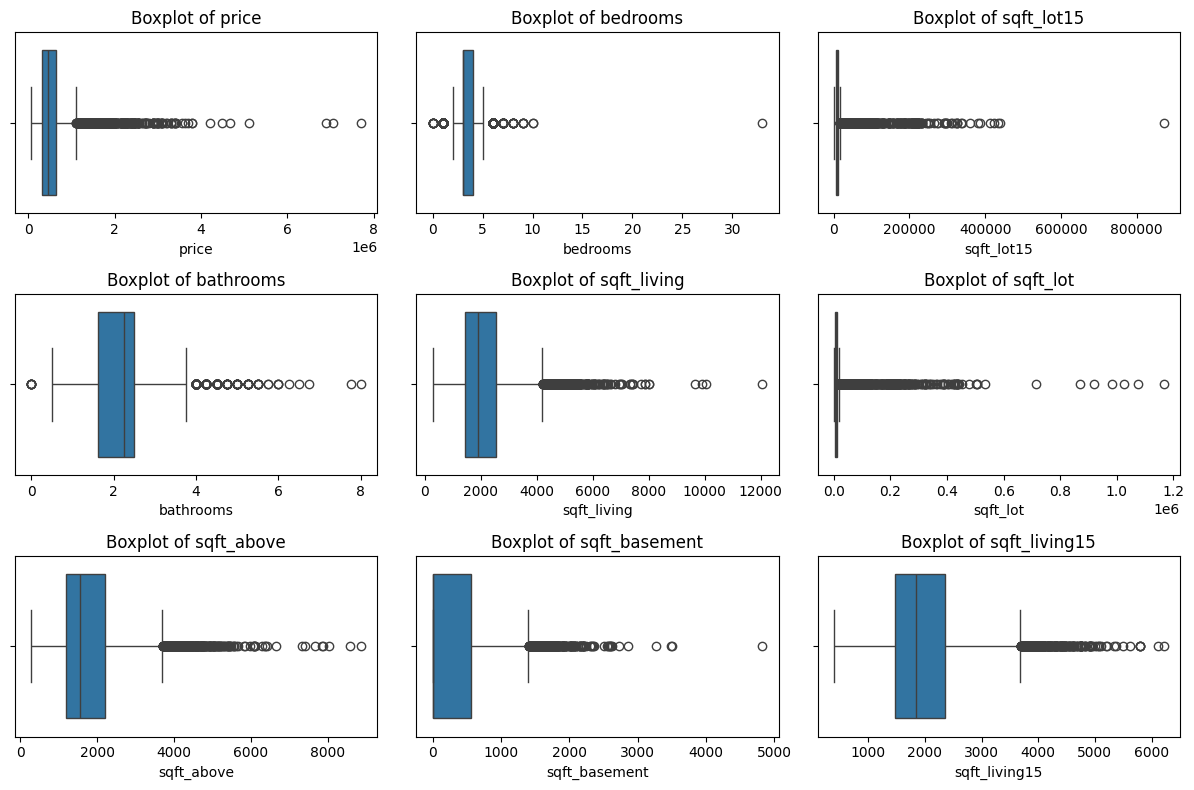

In [6]:
columns=['price', 'bedrooms','sqft_lot15' ,'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15']  # wherever the outlier can be

plt.figure(figsize=(12,8))
for i, col in enumerate(columns,1):
    plt.subplot(3,3,i)
    sns.boxplot(data=df_clean,x=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()           

In [7]:
remove_outl=(df_clean['bedrooms']>15) | (df_clean['sqft_lot15']>600000)
df_clean=df_clean[~remove_outl]
after_count=len(df_clean)
print(after_count)
print("right skewness can be corrected using log transformation later")

16153
right skewness can be corrected using log transformation later


In [8]:
df_clean['wrt_neighbours']=df_clean['sqft_living']/(df_clean['sqft_living15']+0.1)
df_clean['lot_wrt_neighbours']=df_clean['sqft_lot']/(df_clean['sqft_lot15']+0.1)
df_clean['bath_density']=df_clean['bathrooms']/(df_clean['bedrooms']+1)

df_clean['year_since_update']=df_clean['sale_yr']-df_clean[['yr_built','yr_renovated']].max(axis=1)
df_clean['year_since_update'] = df_clean['year_since_update'].clip(lower=0) 

df_clean['situation_house']=df_clean['grade']*df_clean['condition']
df_clean['scenery']=df_clean['view']+(df_clean['waterfront']*3)
df_clean['above_ground_percent']=df_clean['sqft_above']/(df_clean['sqft_living']+0.1)
df_clean['luxury_index'] = df_clean['sqft_living'] * df_clean['grade']
df_clean['age_quality_ratio'] = df_clean['grade'] / (df_clean['year_since_update'] + 1)
df_clean['land_utilization'] = df_clean['sqft_living'] / (df_clean['sqft_lot'] + 0.1)
df_clean['floors'] = df_clean['floors'].clip(lower=1)
df_clean['ground_footprint'] = df_clean['sqft_above'] / df_clean['floors']
df_clean['yard_size'] = (df_clean['sqft_lot'] - df_clean['ground_footprint']).clip(lower=0)
df_clean['relative_size_diff'] = df_clean['sqft_living'] - df_clean['sqft_living15']

In [9]:
# Calculate the mean lat/long of the top 1% most expensive houses
top_houses = df_clean.nlargest(int(len(df_clean) * 0.01), 'price')
center_lat = top_houses['lat'].mean()
center_long = top_houses['long'].mean()

df_clean['dist_from_luxury_hub'] = ((df_clean['lat'] - center_lat)**2 + 
                                    (df_clean['long'] - center_long)**2)**0.5

In [10]:
from scipy.spatial.distance import cdist

waterfront_coords = df_clean[df_clean['waterfront'] == 1][['lat', 'long']].values
all_coords = df_clean[['lat', 'long']].values
# Calculate distance to the closest waterfront property
distances = cdist(all_coords, waterfront_coords, 'euclidean')
df_clean['dist_to_nearest_waterfront'] = distances.min(axis=1)

In [11]:
print(df_clean.columns.tolist())

['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_yr', 'sale_month', 'wrt_neighbours', 'lot_wrt_neighbours', 'bath_density', 'year_since_update', 'situation_house', 'scenery', 'above_ground_percent', 'luxury_index', 'age_quality_ratio', 'land_utilization', 'ground_footprint', 'yard_size', 'relative_size_diff', 'dist_from_luxury_hub', 'dist_to_nearest_waterfront']


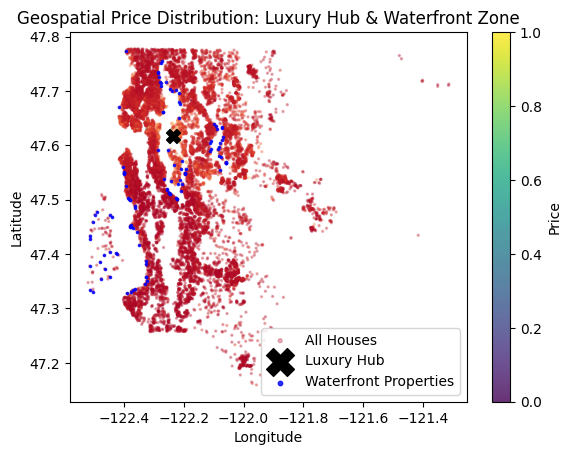

In [12]:
waterfront_houses = df_clean[df_clean['waterfront'] == 1]

plt.scatter(df_clean['long'], df_clean['lat'], 
            c=df_clean['price'], cmap='RdYlGn', 
            s=2, alpha=0.3, label='All Houses')
plt.scatter(center_long, center_lat, color='black', marker='X', s=100, label='Luxury Hub')
plt.scatter(waterfront_houses['long'], waterfront_houses['lat'], 
            color='blue', marker='.', s=10, alpha=0.8, label='Waterfront Properties')

plt.colorbar(label='Price')
plt.title('Geospatial Price Distribution: Luxury Hub & Waterfront Zone')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(markerscale=2)
plt.savefig('geospatial_hubs.png', dpi=300, bbox_inches='tight')

The geospatial distribution reveals that property prices peak near identified luxury hubs and within waterfront clusters, validating the effectiveness of distance-based features and justifying the use of satellite imagery to capture these high-value environmental contexts.

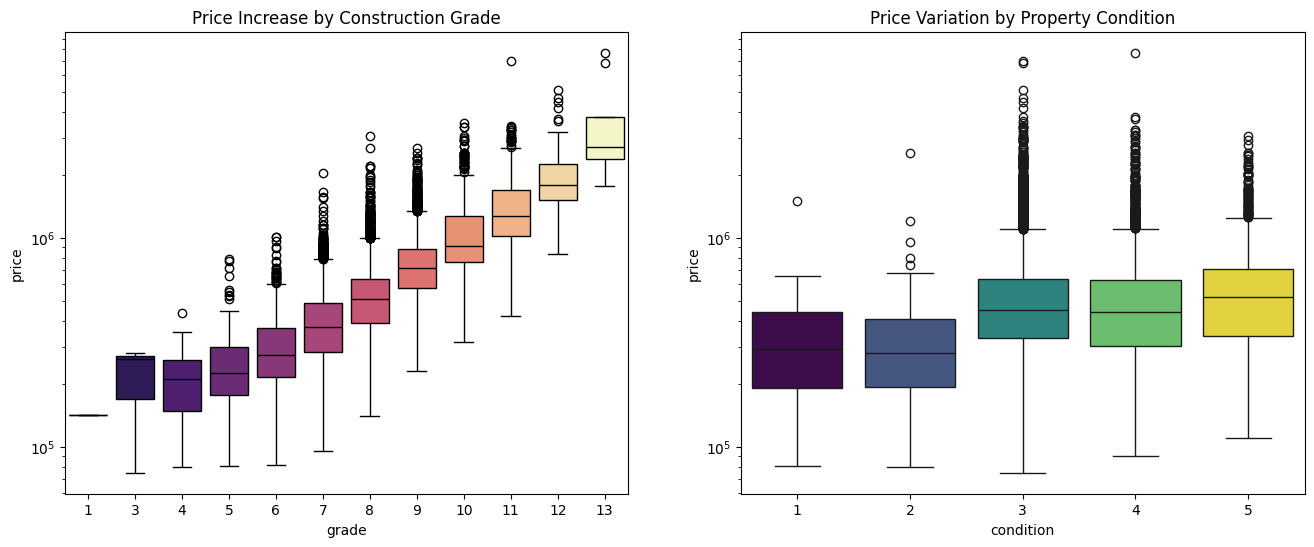

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='grade', y='price', data=df_clean, ax=ax[0], 
            hue='grade', palette='magma', legend=False)
ax[0].set_title('Price Increase by Construction Grade')
ax[0].set_yscale('log') 

sns.boxplot(x='condition', y='price', data=df_clean, ax=ax[1], 
            hue='condition', palette='viridis', legend=False)
ax[1].set_title('Price Variation by Property Condition')
ax[1].set_yscale('log')

plt.show()

Prices increase steadily with higher construction grades, while better property condition also raises prices—but with more overlap, making grade a stronger and more consistent price driver than condition.

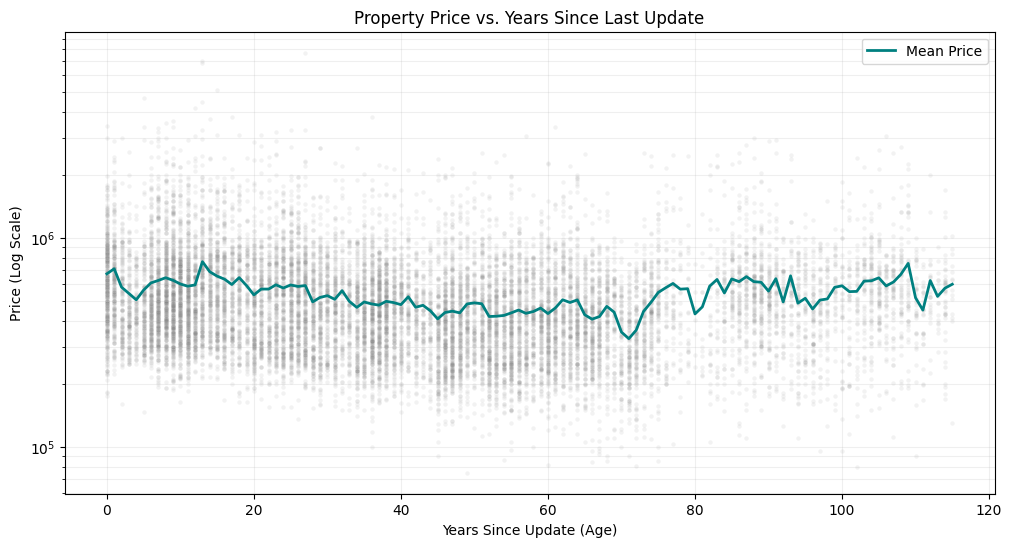

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_clean, x='year_since_update', y='price', alpha=0.1, color='grey', s=10)
sns.lineplot(data=df_clean, x='year_since_update', y='price', color='teal', errorbar=None, linewidth=2, label='Mean Price')

plt.yscale('log') 
plt.title('Property Price vs. Years Since Last Update')
plt.xlabel('Years Since Update (Age)')
plt.ylabel('Price (Log Scale)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

The total property value remains remarkably resilient as house age increases, suggesting that the underlying land value and ongoing maintenance successfully offset the natural aging of the structure.

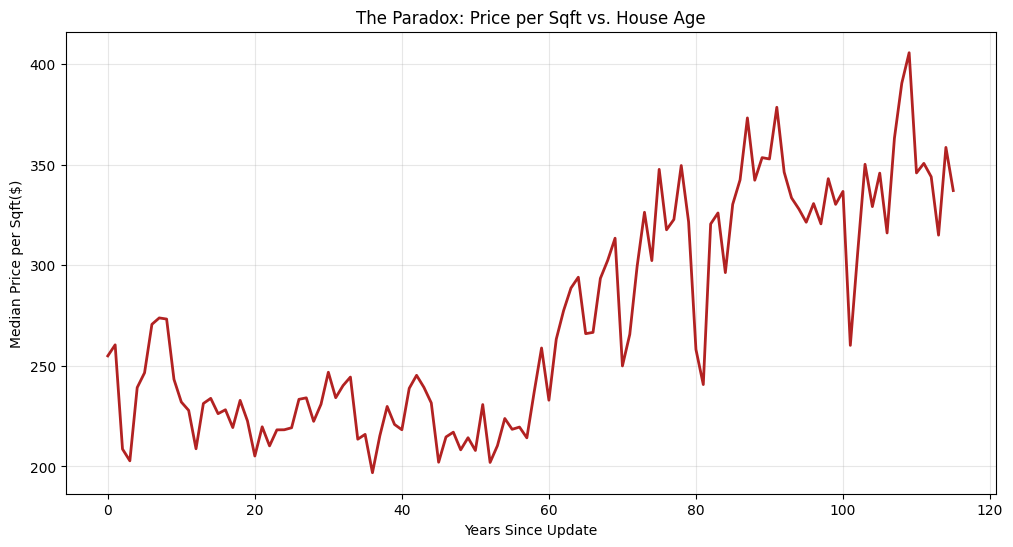

In [15]:
df_clean['price_per_sqft'] = df_clean['price'] / df_clean['sqft_living']
plt.figure(figsize=(12, 6))

age_trend = df_clean.groupby('year_since_update')['price_per_sqft'].median().reset_index()

sns.lineplot(data=age_trend, x='year_since_update', y='price_per_sqft', color='firebrick', linewidth=2)
plt.title('The Paradox: Price per Sqft vs. House Age')
plt.xlabel('Years Since Update')
plt.ylabel('Median Price per Sqft($)')
plt.grid(True, alpha=0.3)
plt.show()

The upward trend in price per square foot for older properties reveals a dominant 'location and character premium' that my multimodal pipeline will quantify by extracting visual environmental context from satellite imagery.

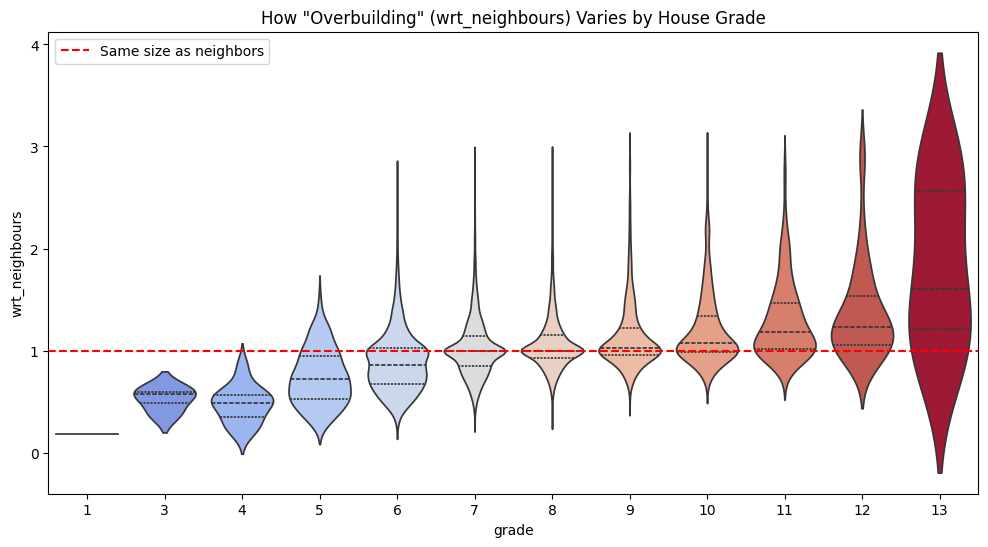

In [16]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='grade', y='wrt_neighbours', 
               data=df_clean[df_clean['wrt_neighbours'] < 3], 
               hue='grade', palette='coolwarm', inner="quart", legend=False)
plt.axhline(1, color='red', linestyle='--', label='Same size as neighbors')
plt.title('How "Overbuilding" (wrt_neighbours) Varies by House Grade')
plt.legend()
plt.show()

The correlation between higher quality grades and 'overbuilding' relative to neighbors identifies a luxury signature thatmy multimodal model will capture by using satellite imagery to analyze the property's scale within its local neighborhood context.

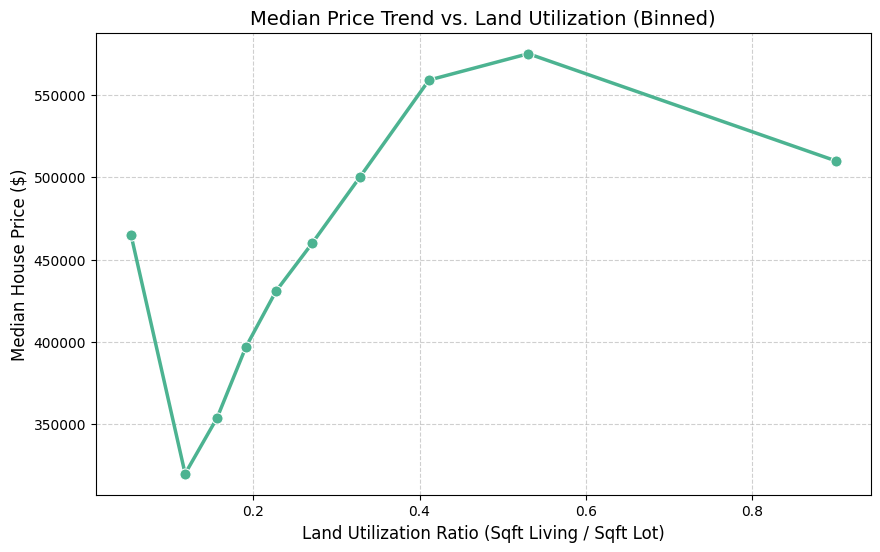

In [17]:
df_clean['util_bins'] = pd.qcut(df_clean['land_utilization'], 10, labels=False)

bin_metrics = df_clean.groupby('util_bins').agg({
    'land_utilization': 'median',
    'price': 'median'
}).reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=bin_metrics, x='land_utilization', y='price', 
             marker='o', markersize=8, color='#4CB391', linewidth=2.5)

plt.title('Median Price Trend vs. Land Utilization (Binned)', fontsize=14)
plt.xlabel('Land Utilization Ratio (Sqft Living / Sqft Lot)', fontsize=12)
plt.ylabel('Median House Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

The price first drops, then rises as the house covers more of the land, and finally dips slightly, showing there is a 'sweet spot' for land use that our model can identify by looking at property footprints in satellite images.

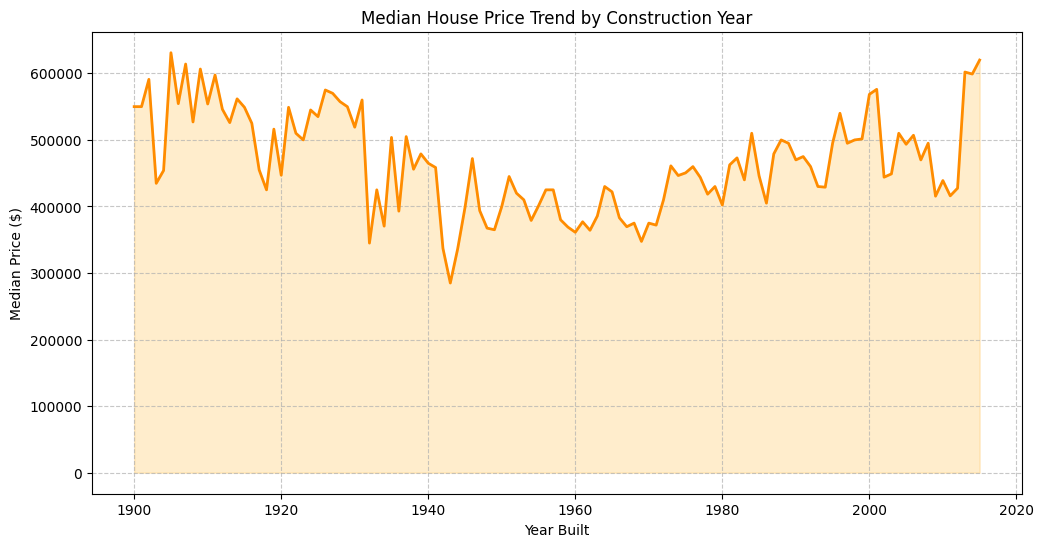

In [18]:
plt.figure(figsize=(12, 6))

age_trend = df_clean.groupby('yr_built')['price'].median()
plt.plot(age_trend.index, age_trend.values, color='darkorange', linewidth=2)
plt.fill_between(age_trend.index, age_trend.values, color='orange', alpha=0.2) # Area Plot effect
plt.title('Median House Price Trend by Construction Year')
plt.xlabel('Year Built')
plt.ylabel('Median Price ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The price goes up and down depending on the era the house was built, showing that both 'historic charm' and 'modern luxury' create value that our model can see in satellite photos.

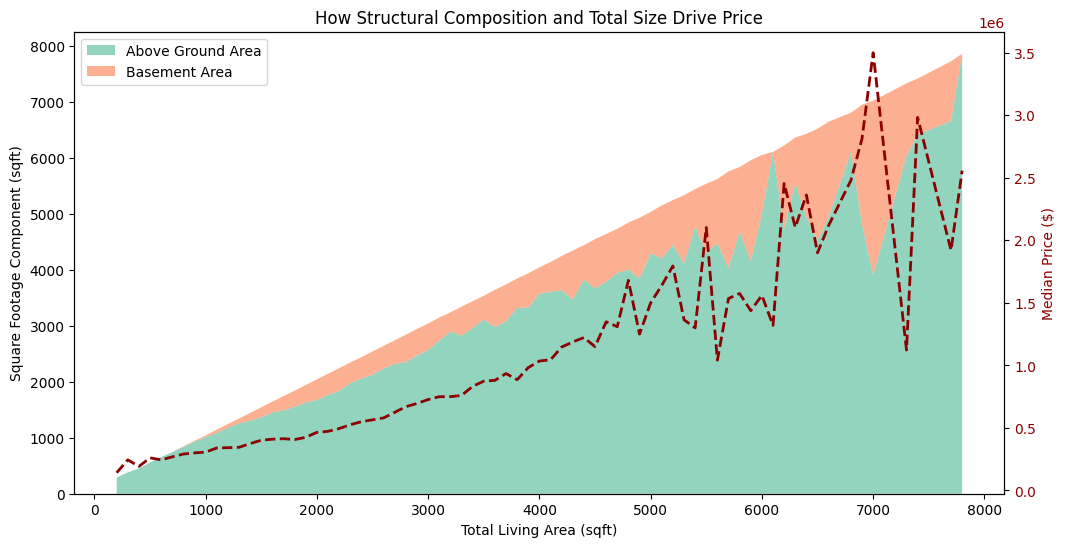

In [19]:
df_clean['size_bin'] = (df_clean['sqft_living'] // 100) * 100
area_price_comp = df_clean.groupby('size_bin').agg({
    'sqft_above': 'mean',
    'sqft_basement': 'mean',
    'price': 'median'
}).reset_index()

area_price_comp = area_price_comp[area_price_comp['size_bin'] < 8000]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.stackplot(area_price_comp['size_bin'], 
              area_price_comp['sqft_above'], 
              area_price_comp['sqft_basement'], 
              labels=['Above Ground Area', 'Basement Area'], 
              colors=['#66c2a5', '#fc8d62'], alpha=0.7)
ax1.set_xlabel('Total Living Area (sqft)')
ax1.set_ylabel('Square Footage Component (sqft)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx() 
ax2.plot(area_price_comp['size_bin'], area_price_comp['price'], 
         color='darkred', linewidth=2, label='Median Price', linestyle='--')
ax2.set_ylabel('Median Price ($)', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

plt.title('How Structural Composition and Total Size Drive Price')
plt.show()

The price goes up as the house gets bigger, and it shows that houses with basements (the orange part) usually sell for more than houses that only have a main floor.

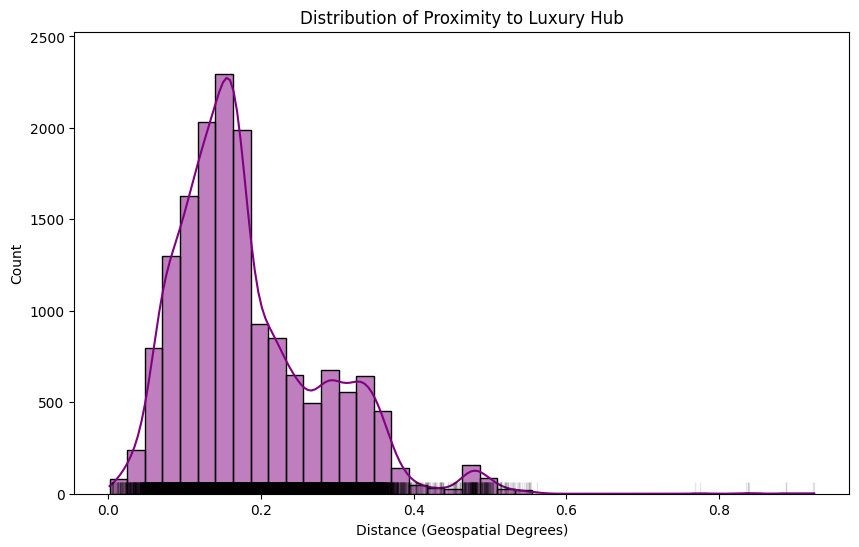

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['dist_from_luxury_hub'], bins=40, kde=True, color='purple')
sns.rugplot(df_clean['dist_from_luxury_hub'], color='black', alpha=0.1) 
plt.title('Distribution of Proximity to Luxury Hub')
plt.xlabel('Distance (Geospatial Degrees)')
plt.show()

Most houses are located very close to luxury hubs, showing that the dataset is focused on high-value areas where location is a major factor in the final price."

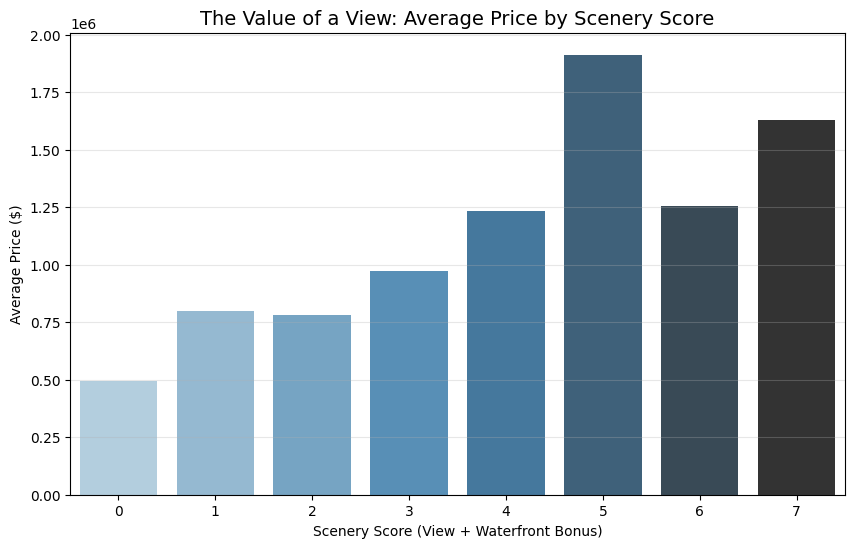

In [21]:
plt.figure(figsize=(10, 6))
scenery_price = df_clean.groupby('scenery')['price'].mean().sort_index().reset_index()

sns.barplot(x='scenery', y='price', data=scenery_price, 
            hue='scenery', palette='Blues_d', legend=False)

plt.title('The Value of a View: Average Price by Scenery Score', fontsize=14)
plt.ylabel('Average Price ($)')
plt.xlabel('Scenery Score (View + Waterfront Bonus)')
plt.grid(axis='y', alpha=0.3)
plt.show()

The average price jumps the highest when a house has both a waterfront and a great view , showing that these 'luxury combinations' add more value than any other single feature.

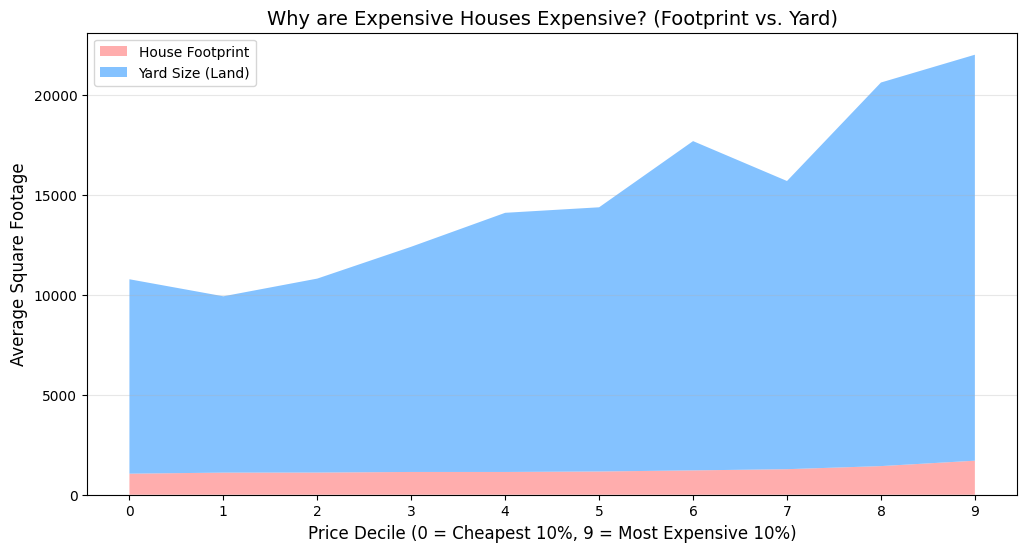

In [22]:
df_clean = df_clean.copy()
df_clean.loc[:, 'price_bin'] = pd.qcut(df_clean['price'], 10, labels=False)
area_stats = df_clean.groupby('price_bin')[['ground_footprint', 'yard_size']].mean()

plt.figure(figsize=(12, 6))
plt.stackplot(area_stats.index, 
              area_stats['ground_footprint'], 
              area_stats['yard_size'], 
              labels=['House Footprint', 'Yard Size (Land)'], 
              colors=['#ff9999','#66b3ff'], 
              alpha=0.8)
plt.title('Why are Expensive Houses Expensive? (Footprint vs. Yard)', fontsize=14)
plt.xlabel('Price Decile (0 = Cheapest 10%, 9 = Most Expensive 10%)', fontsize=12)
plt.ylabel('Average Square Footage', fontsize=12)
plt.xticks(range(10))
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)

plt.show()

This plot focuses on total area as price increases. It shows that for the most expensive homes, the actual size of the house (footprint) barely changes, while the amount of land (yard size) grows massively.

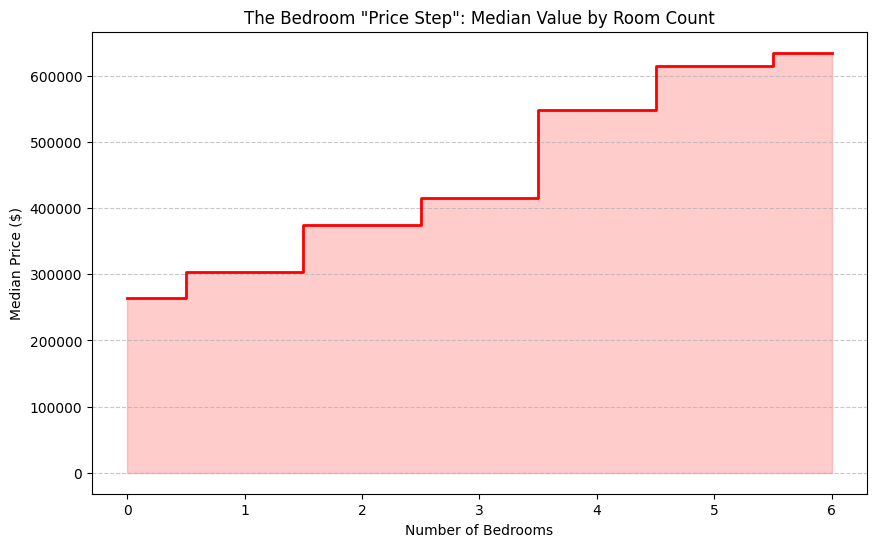

In [23]:
plt.figure(figsize=(10, 6))
bed_price = df_clean.groupby('bedrooms')['price'].median().sort_index()
# Filter out extreme outliers 
bed_price = bed_price[bed_price.index <= 6] 

plt.step(bed_price.index, bed_price.values, where='mid', color='red', linewidth=2)
plt.fill_between(bed_price.index, bed_price.values, step="mid", alpha=0.2, color='red')
plt.title('The Bedroom "Price Step": Median Value by Room Count')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Median Price ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Each extra bedroom adds a clear 'step' up in price, showing that room count is a reliable predictor of value that works alongside the physical size of the house.

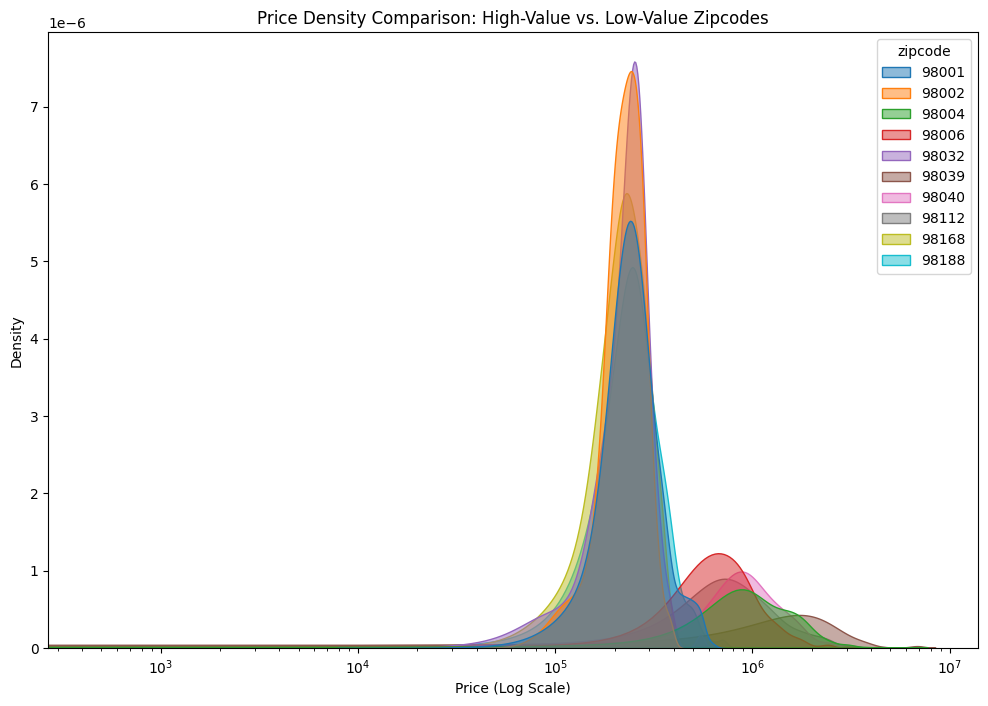

In [24]:
# Identify top and bottom zipcodes by median price
top_zips = df_clean.groupby('zipcode')['price'].median().nlargest(5).index
bot_zips = df_clean.groupby('zipcode')['price'].median().nsmallest(5).index
target_zips = list(top_zips) + list(bot_zips)

plt.figure(figsize=(12, 8))

subset = df_clean[df_clean['zipcode'].isin(target_zips)]

sns.kdeplot(data=subset, x="price", hue="zipcode", fill=True, common_norm=False, palette="tab10", alpha=0.5)
plt.xscale('log')
plt.title('Price Density Comparison: High-Value vs. Low-Value Zipcodes')
plt.xlabel('Price (Log Scale)')
plt.ylabel('Density')
plt.show()

The huge gap between the peaks shows that homes in high-value zipcodes occupy an entirely different price bracket, proving that location is a fundamental 'anchor' for value in my model

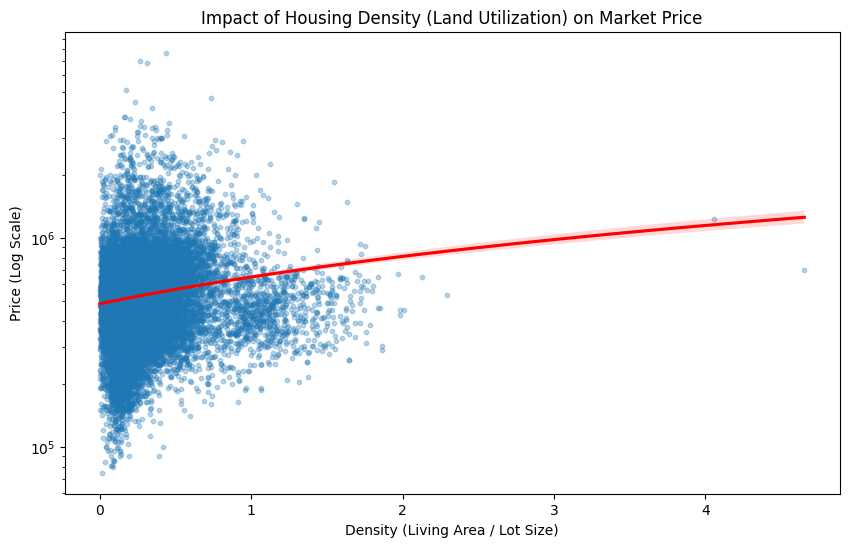

In [25]:

plt.figure(figsize=(10, 6))
sns.regplot(data=df_clean, x='land_utilization', y='price', 
            scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})
plt.yscale('log')
plt.title('Impact of Housing Density (Land Utilization) on Market Price')
plt.xlabel('Density (Living Area / Lot Size)')
plt.ylabel('Price (Log Scale)')
plt.show()

For the majority of homes, the market rewards 'efficiency'—meaning the more living space you can fit onto a lot, the higher the price goes.

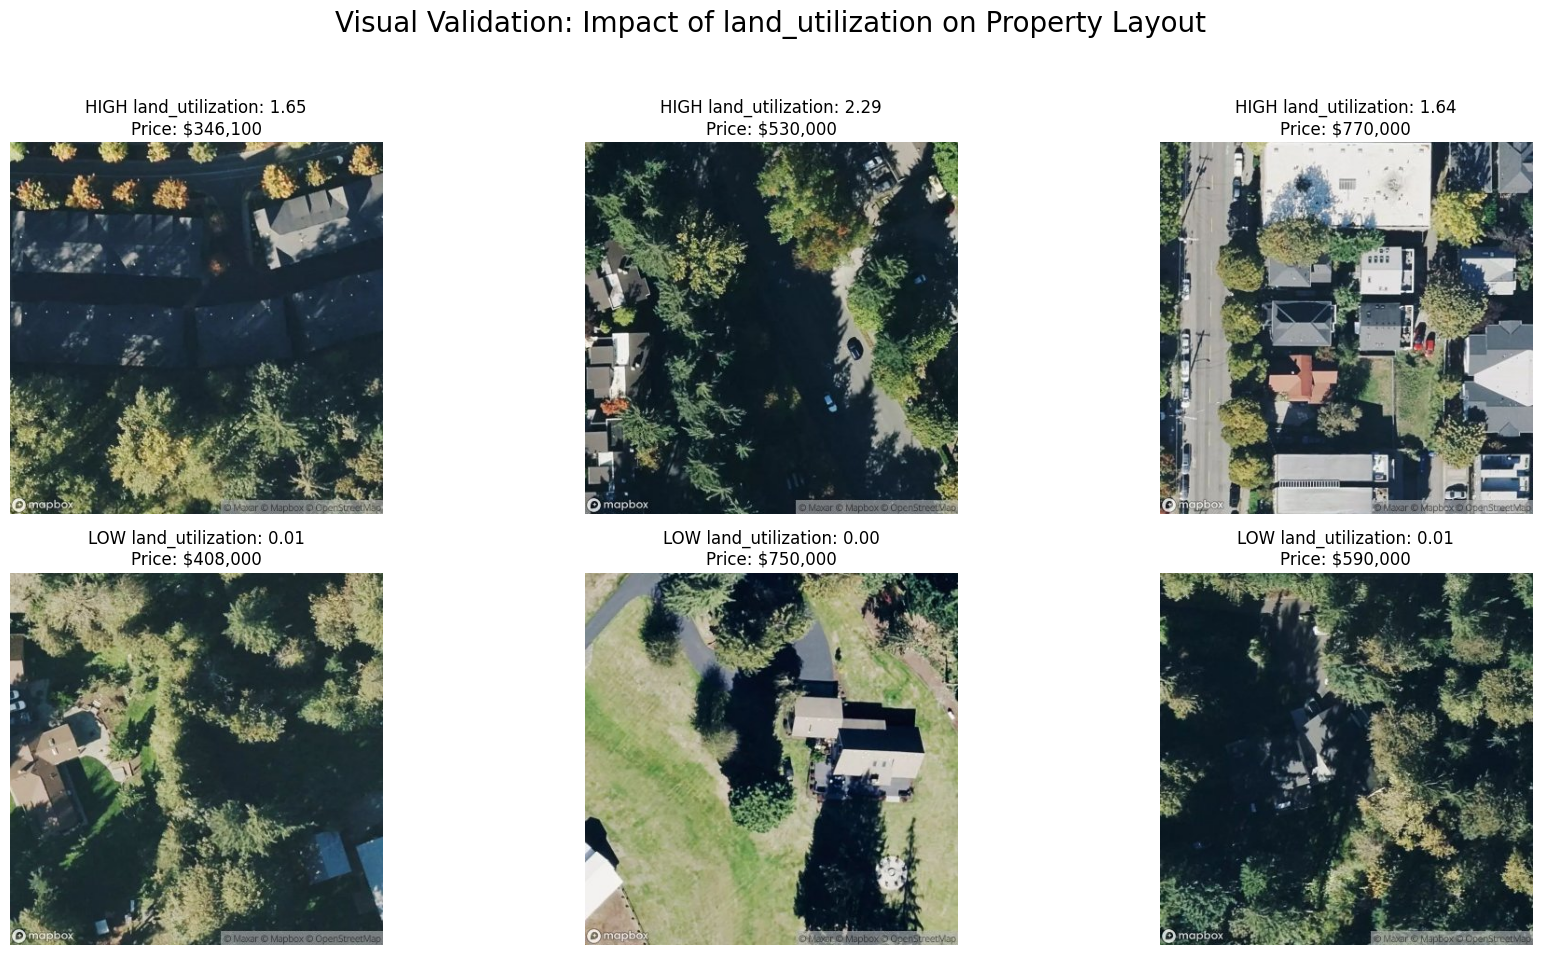

In [26]:
import PIL.Image
import os

def contrast_feature_images(df, image_path, feature='land_utilization'):
    # Get 3 houses from the 95th percentile (High Utilization)
    high_val = df.nlargest(50, feature).sample(3)
    # Get 3 houses from the 5th percentile (Low Utilization)
    low_val = df.nsmallest(50, feature).sample(3)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plotting High Values (Top Row)
    for i, (idx, row) in enumerate(high_val.iterrows()):
        img_name = f"{int(row['id'])}.jpg"
        full_path = os.path.join(image_path, img_name)
        if os.path.exists(full_path):
            img = PIL.Image.open(full_path)
            axes[0, i].imshow(img)
            axes[0, i].set_title(f"HIGH {feature}: {row[feature]:.2f}\nPrice: ${row['price']:,.0f}")
        axes[0, i].axis('off')
        
    # Plotting Low Values (Bottom Row)
    for i, (idx, row) in enumerate(low_val.iterrows()):
        img_name = f"{int(row['id'])}.jpg"
        full_path = os.path.join(image_path, img_name)
        if os.path.exists(full_path):
            img = PIL.Image.open(full_path)
            axes[1, i].imshow(img)
            axes[1, i].set_title(f"LOW {feature}: {row[feature]:.2f}\nPrice: ${row['price']:,.0f}")
        axes[1, i].axis('off')

    plt.suptitle(f"Visual Validation: Impact of {feature} on Property Layout", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
contrast_feature_images(df_clean, "house_images_dataset/zoom_18")

The satellite photos clearly show two different ways to build value: high-density properties (top row) maximize every inch of land with large buildings for higher prices, while low-density properties (bottom row) gain their value from massive open green spaces and privacy.

<Axes: xlabel='relative_size_diff', ylabel='price'>

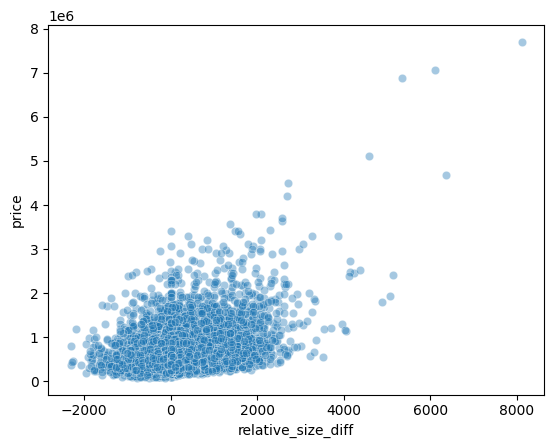

In [27]:
sns.scatterplot(
    x='relative_size_diff',
    y='price',
    data=df_clean,
    alpha=0.4
)

Houses that are significantly larger than their neighbors (positive relative size) show much higher price potential, proving that being the 'biggest house on the block' creates a luxury premium.

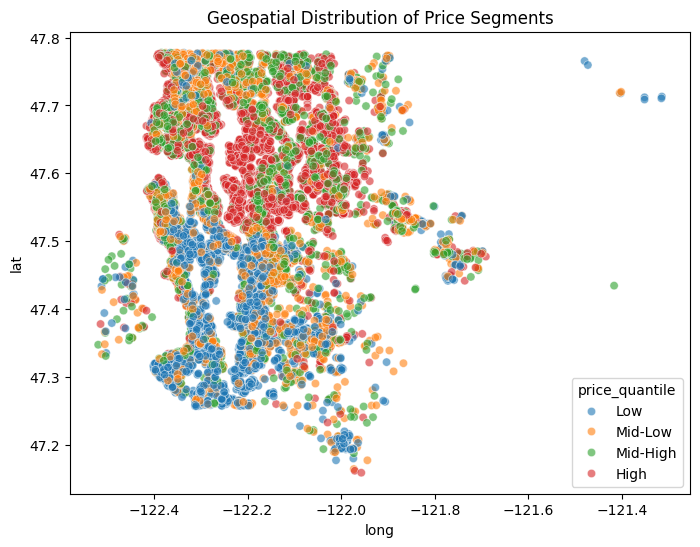

In [28]:
df_clean['price_quantile'] = pd.qcut(
    df_clean['price'], 4,
    labels=['Low','Mid-Low','Mid-High','High']
)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='long',
    y='lat',
    hue='price_quantile',
    data=df_clean,
    alpha=0.6
)
plt.title('Geospatial Distribution of Price Segments')
plt.show()

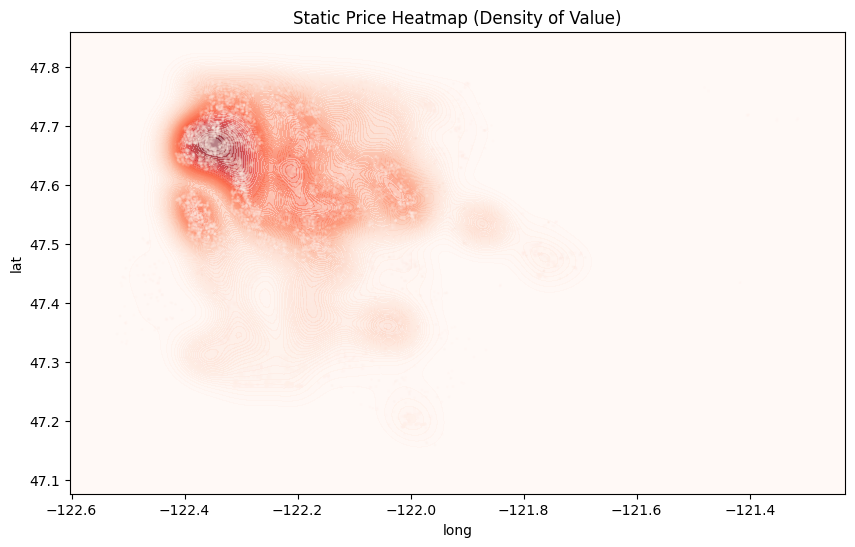

In [29]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_clean, x="long", y="lat", 
    weights="price", cmap="Reds", 
    fill=True, thresh=0, levels=100, alpha=0.5
)
plt.scatter(df_clean['long'], df_clean['lat'], c=df_clean['price'], s=1, cmap='Reds', alpha=0.1)
plt.title("Static Price Heatmap (Density of Value)")
plt.show()


The heatmap shows that house prices are not spread out evenly; instead, value is heavily concentrated in specific 'hotspots,' proving that where a house is located is just as important as how big it is

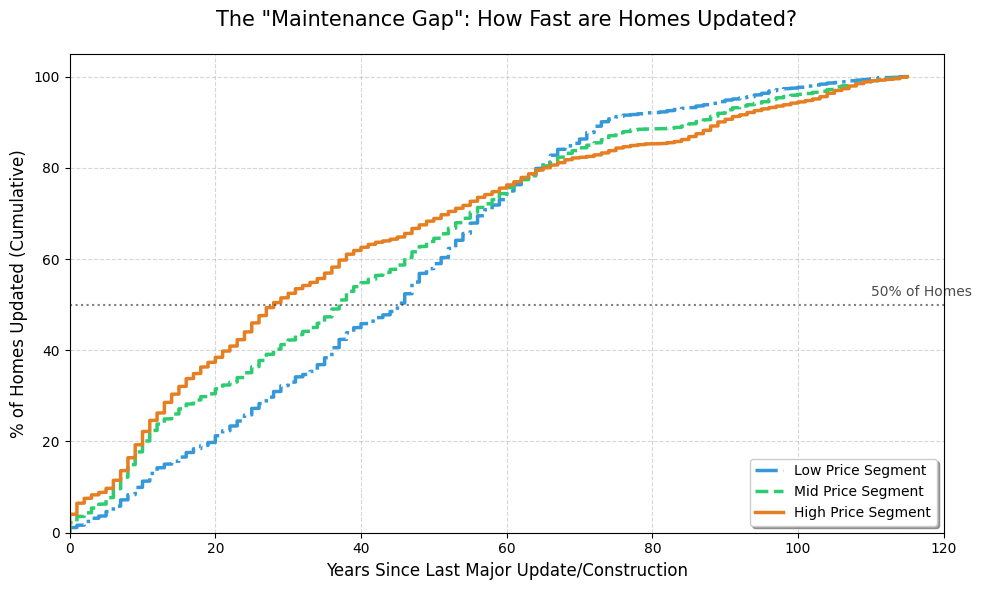

In [30]:
from statsmodels.distributions.empirical_distribution import ECDF

df_clean.loc[:, 'price_segment'] = pd.qcut(df_clean['price'], 3, 
                                          labels=['Low', 'Mid', 'High'])
plt.figure(figsize=(10, 6))

colors = {'High': '#e67e22', 'Mid': '#2ecc71', 'Low': '#3498db'}
styles = {'High': '-', 'Mid': '--', 'Low': '-.'}

for seg in ['Low', 'Mid', 'High']:
    data = df_clean[df_clean['price_segment'] == seg]['year_since_update']
    ecdf = ECDF(data)
    
    plt.plot(ecdf.x, ecdf.y * 100, label=f'{seg} Price Segment', 
             color=colors[seg], linestyle=styles[seg], linewidth=2.5)

# Add the 50% Median Marker
plt.axhline(50, color='black', linestyle=':', alpha=0.5)
plt.text(110, 52, '50% of Homes', fontsize=10, alpha=0.7)

plt.title('The "Maintenance Gap": How Fast are Homes Updated?', fontsize=15, pad=20)
plt.xlabel('Years Since Last Major Update/Construction', fontsize=12)
plt.ylabel('% of Homes Updated (Cumulative)', fontsize=12)
plt.ylim(0, 105)
plt.xlim(0, 120)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(loc='lower right', frameon=True, shadow=True)

plt.tight_layout()
plt.show()

Expensive homes are renovated much more frequently than cheaper ones, with over 60% of high-end homes being updated in the last 40 years compared to less than 40% of low-end homes

In [31]:
print(df_clean.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_yr', 'sale_month',
       'wrt_neighbours', 'lot_wrt_neighbours', 'bath_density',
       'year_since_update', 'situation_house', 'scenery',
       'above_ground_percent', 'luxury_index', 'age_quality_ratio',
       'land_utilization', 'ground_footprint', 'yard_size',
       'relative_size_diff', 'dist_from_luxury_hub',
       'dist_to_nearest_waterfront', 'price_per_sqft', 'util_bins', 'size_bin',
       'price_bin', 'price_quantile', 'price_segment'],
      dtype='object')


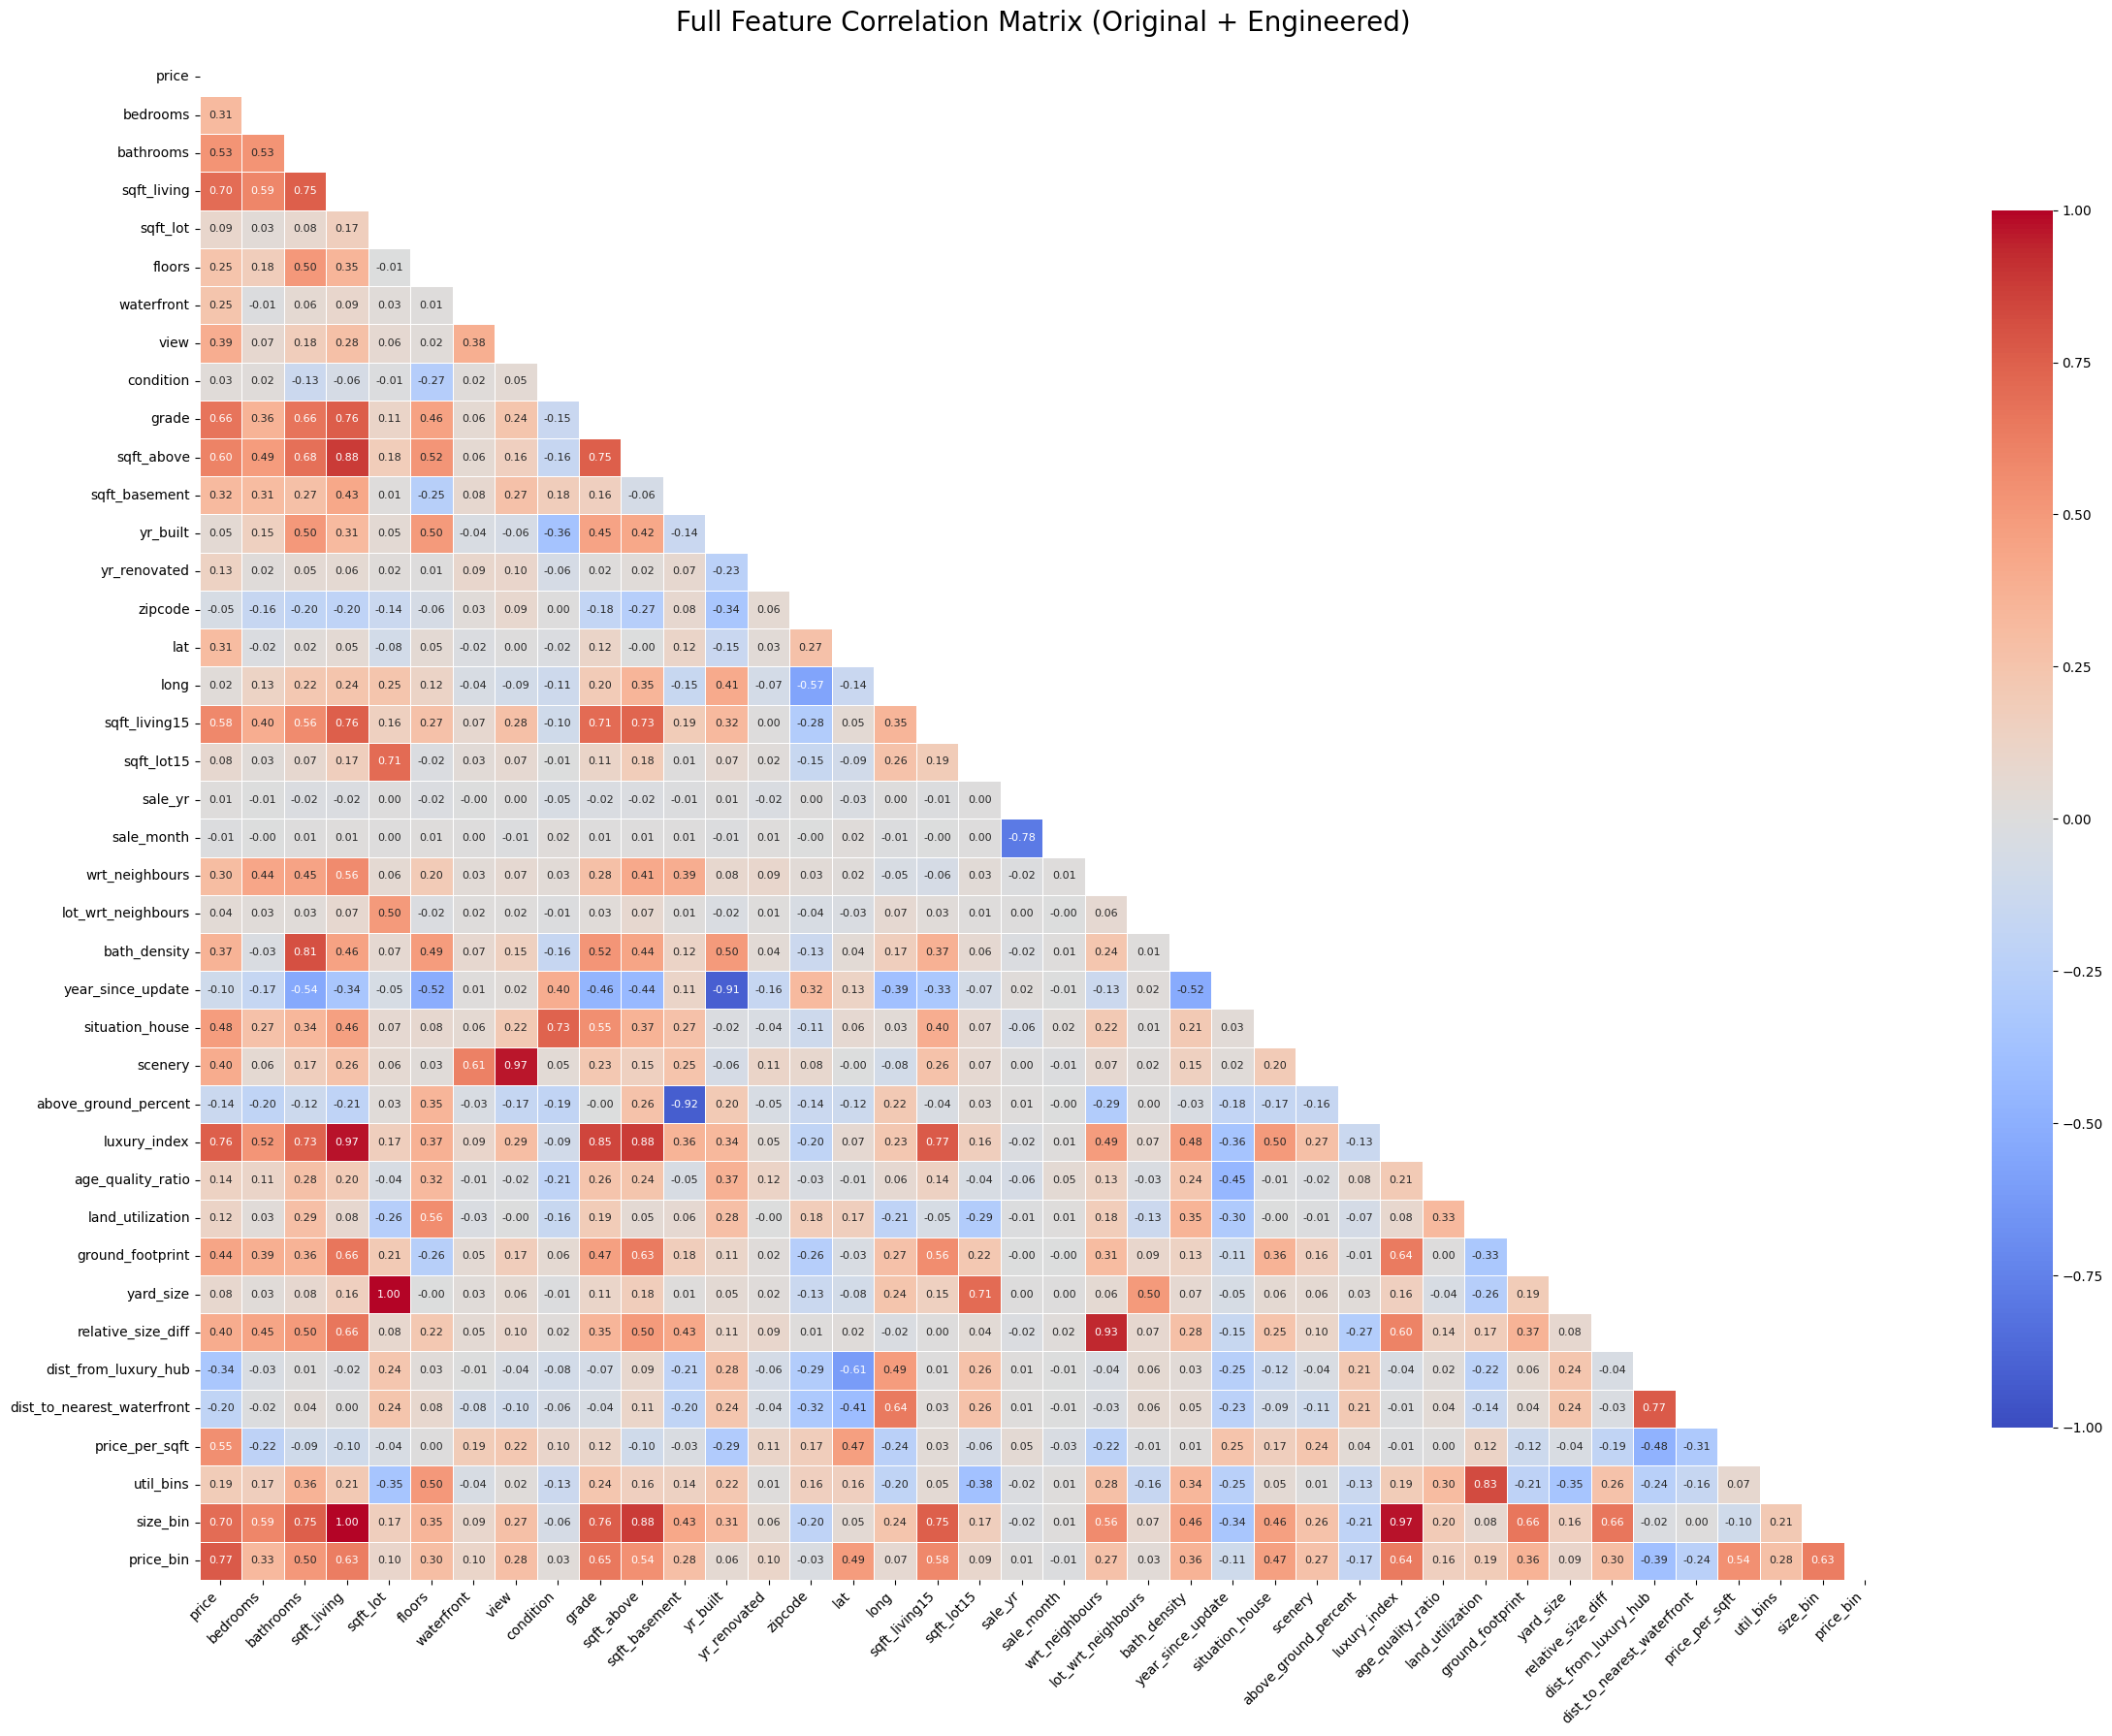

In [32]:
corr_matrix = df_clean.select_dtypes(include=[np.number]).drop(columns=['id'], errors='ignore').corr()
plt.figure(figsize=(24, 18))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
heatmap = sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True,           
    fmt=".2f",            
    cmap='coolwarm',      
    vmin=-1, vmax=1,      
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8} 
)
plt.title('Full Feature Correlation Matrix (Original + Engineered)', fontsize=20, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

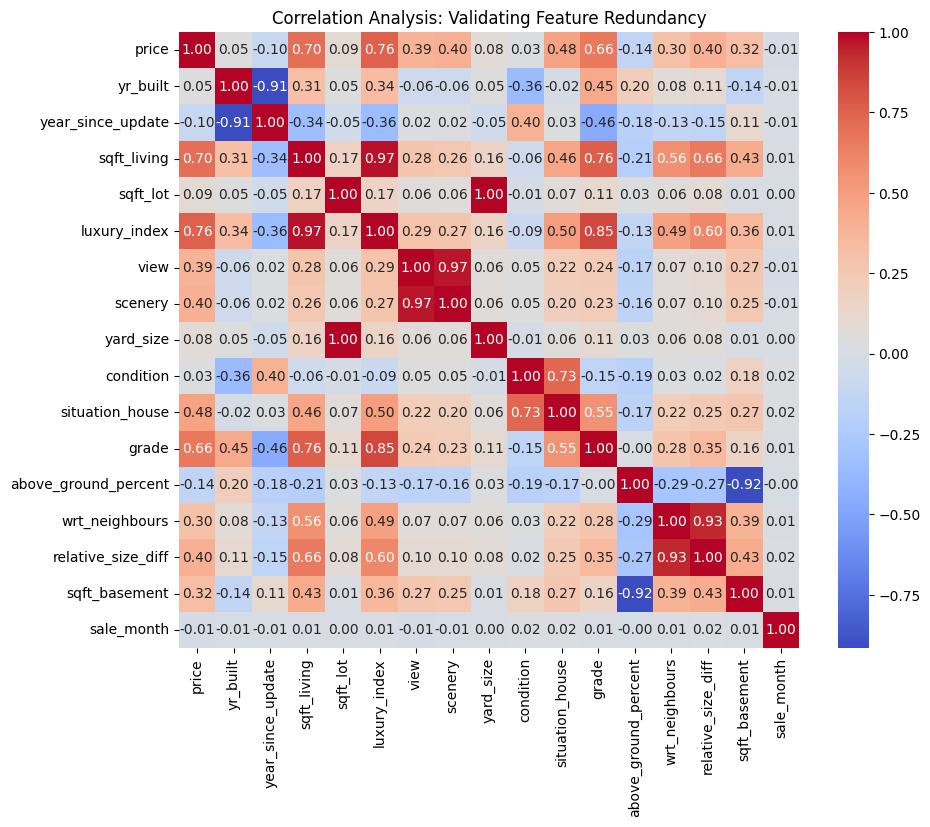

In [33]:
corr_cols = ['price', 'yr_built', 'year_since_update', 'sqft_living', 'sqft_lot','luxury_index', 'view', 'scenery','yard_size','condition','situation_house','grade','above_ground_percent','wrt_neighbours','relative_size_diff','sqft_basement','sale_month']
matrix = df_clean[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Analysis: Validating Feature Redundancy")
plt.show()

This heatmap is created to check the multicollinearity

In [42]:
# List of columns to remove based on your statistical analysis and project goals
cols_to_remove = [               
    'date',              
    'sqft_living',       
    'sqft_lot',          
    'condition',        
    'sqft_basement' ,  
    'view',              
    'wrt_neighbours',    
    'yr_built',           
    'price_segment', 'price_quantile',
    'util_bins', 'price_per_sqft_of', 'price_per_sqft',
    'size_bin', 'has_basement', 'price_bin','sale_month'
]

df_final = df_clean.drop(columns=cols_to_remove, errors='ignore')

print(f"Remaining features for training: {df_final.columns.tolist()}")
print(f"Shape of dataset after selection: {df_final.shape}")

Remaining features for training: ['id', 'price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'grade', 'sqft_above', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_yr', 'lot_wrt_neighbours', 'bath_density', 'year_since_update', 'situation_house', 'scenery', 'above_ground_percent', 'luxury_index', 'age_quality_ratio', 'land_utilization', 'ground_footprint', 'yard_size', 'relative_size_diff', 'dist_from_luxury_hub', 'dist_to_nearest_waterfront']
Shape of dataset after selection: (16153, 29)


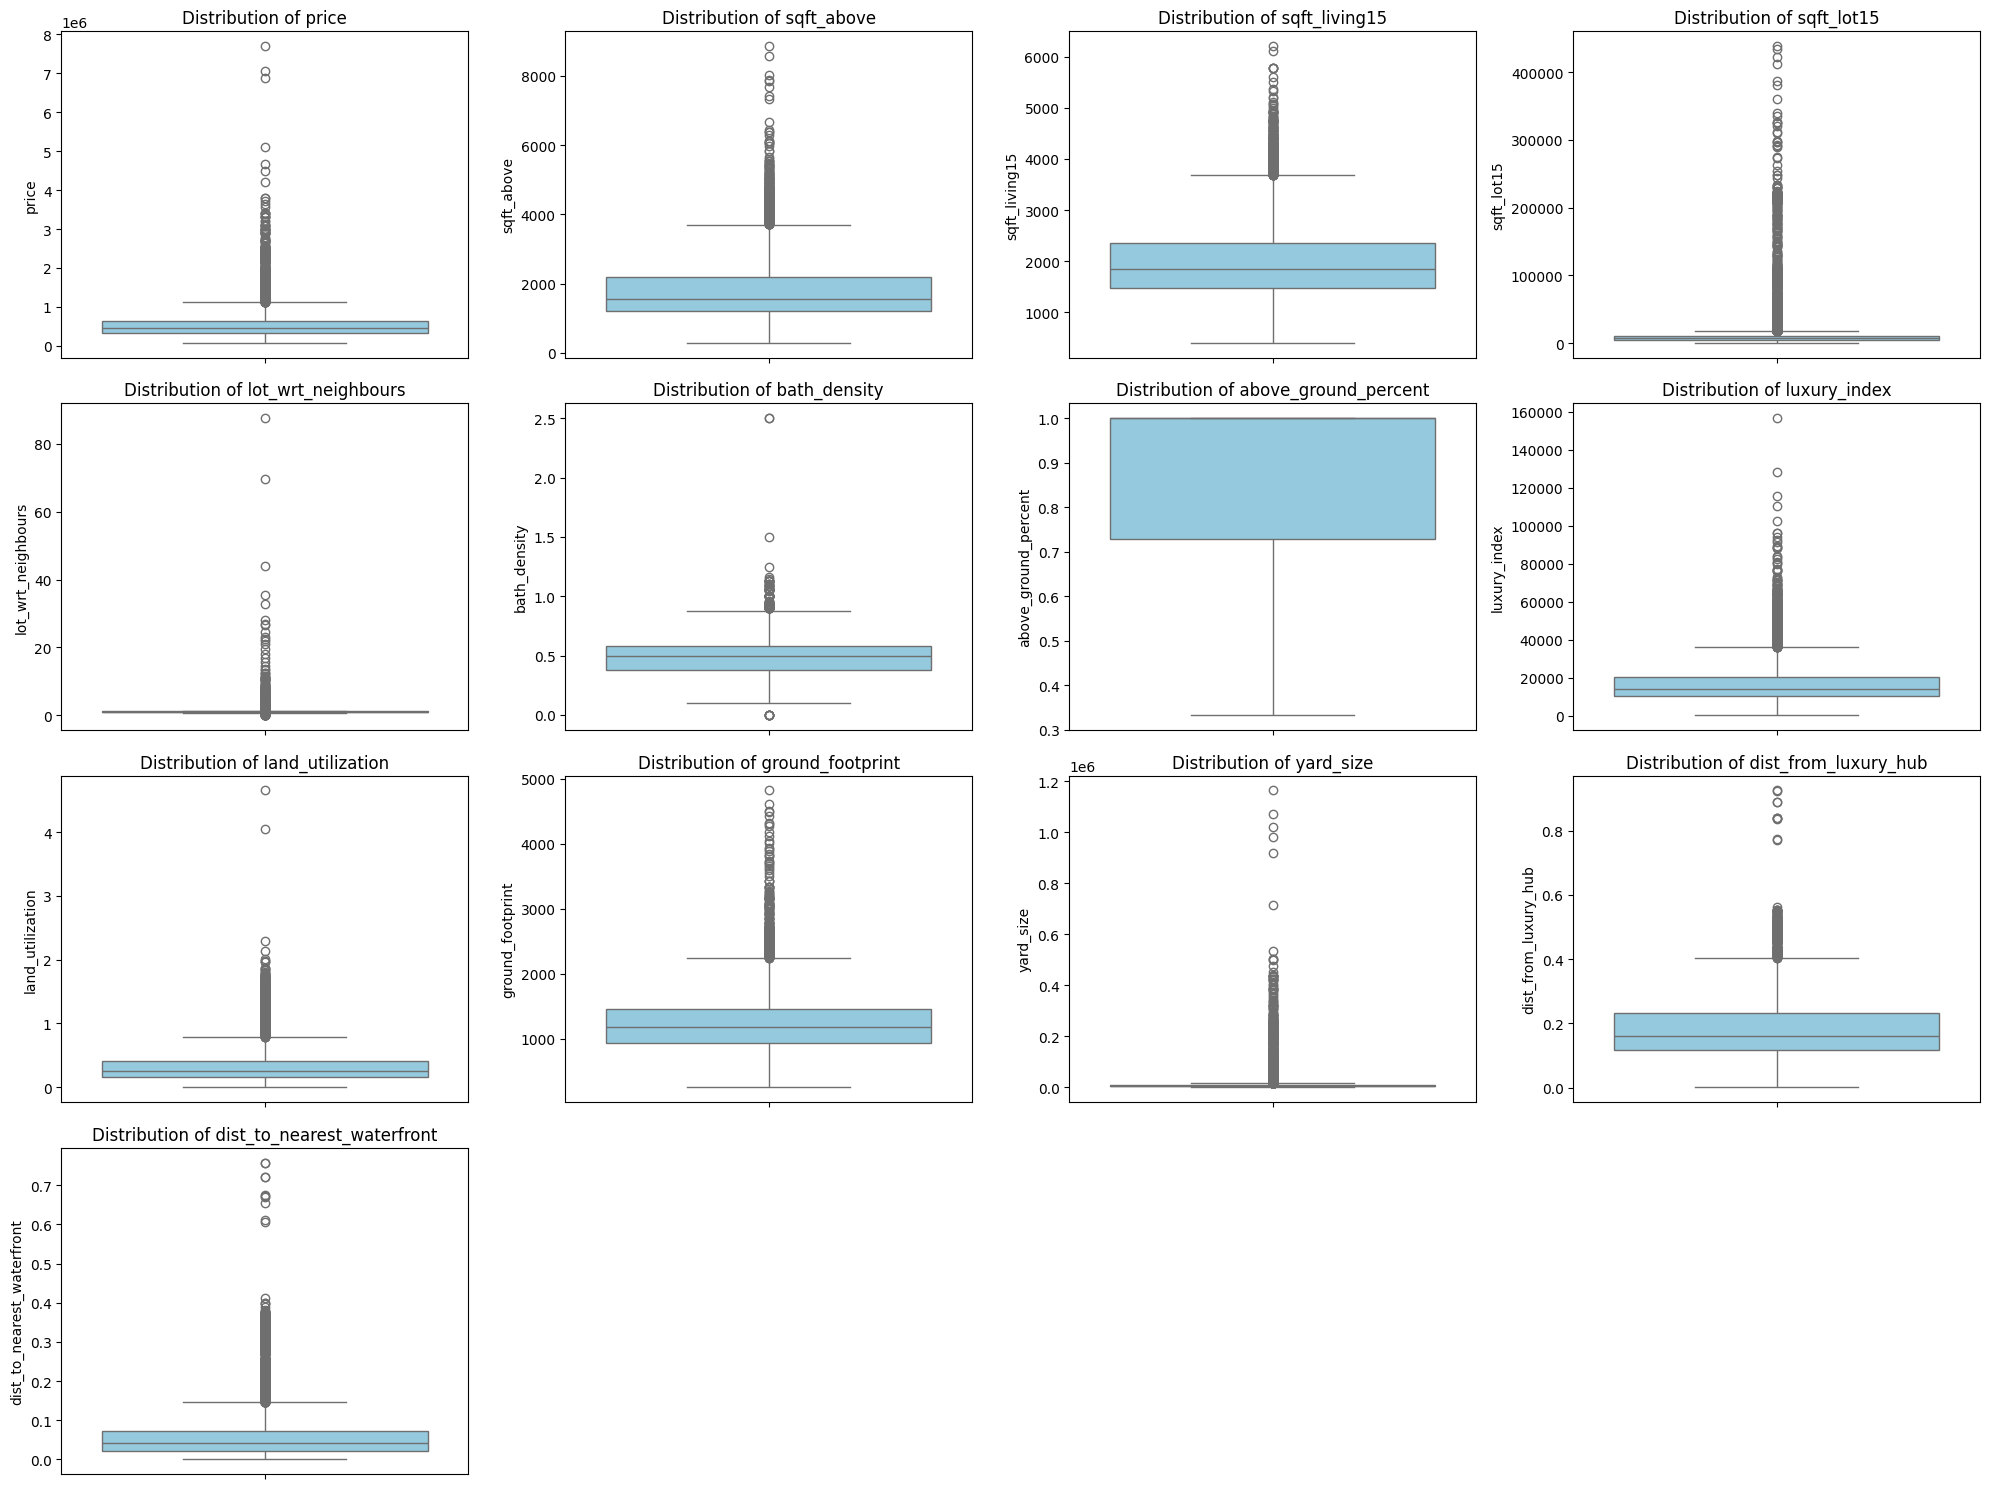

In [35]:
features_to_check = [
    'price', 'sqft_above',  'sqft_living15', 'sqft_lot15',
    'lot_wrt_neighbours', 'bath_density', 'above_ground_percent', 
    'luxury_index', 'land_utilization', 'ground_footprint', 
    'yard_size', 'dist_from_luxury_hub', 'dist_to_nearest_waterfront'
]
plt.figure(figsize=(20, 15))
for i, col in enumerate(features_to_check):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df_final[col], color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

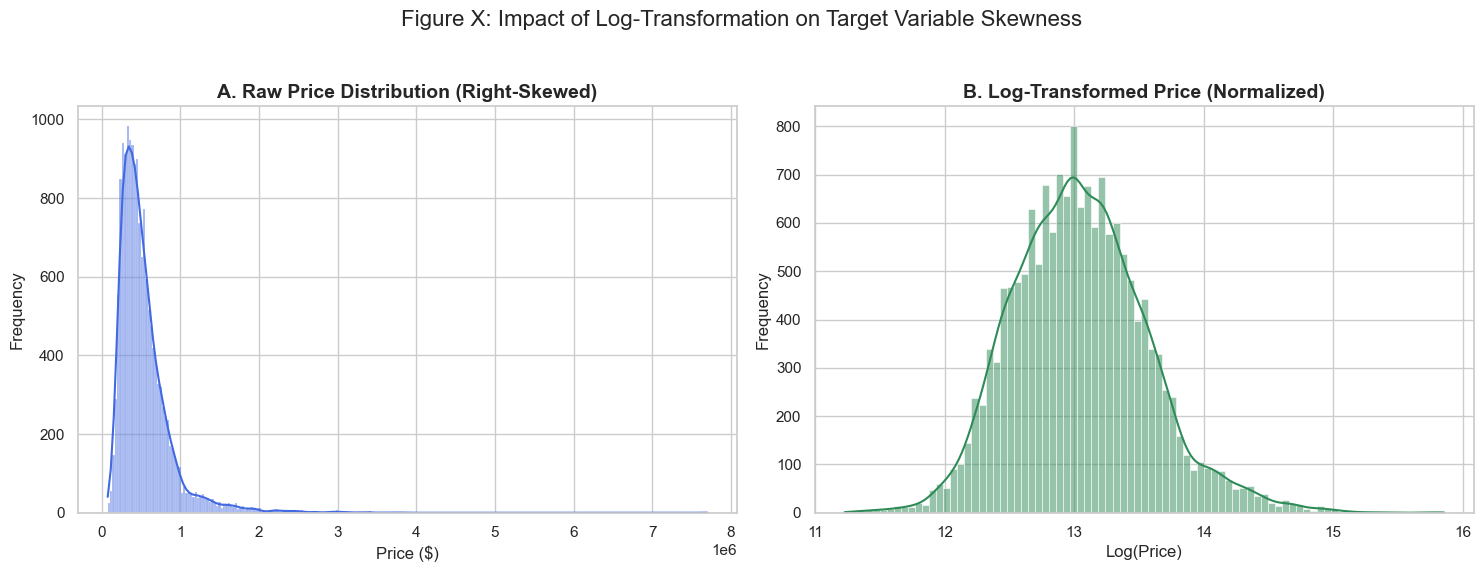

Original Skewness: 4.04
Log-Transformed Skewness: 0.41


In [36]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df_clean['price'], kde=True, ax=axes[0], color='royalblue')
axes[0].set_title('A. Raw Price Distribution (Right-Skewed)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

sns.histplot(np.log1p(df_clean['price']), kde=True, ax=axes[1], color='seagreen')
axes[1].set_title('B. Log-Transformed Price (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log(Price)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.suptitle('Figure X: Impact of Log-Transformation on Target Variable Skewness', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('price_distribution_comparison.png', dpi=300)
plt.show()

print(f"Original Skewness: {df_clean['price'].skew():.2f}")
print(f"Log-Transformed Skewness: {np.log1p(df_clean['price']).skew():.2f}")

Plotting Boxplots to see skewness and decide which feature need to be log transformed

In [37]:
# Features identified as highly skewed
to_log = [
    'price', 'sqft_above' ,'sqft_living15', 'sqft_lot15', 
    'luxury_index', 'ground_footprint', 'yard_size', 'land_utilization','dist_from_luxury_hub','dist_to_nearest_waterfront','lot_wrt_neighbours'
]
# Check for any remaining NaNs or Infinite values
print("Any NaNs left?:", df_final[to_log].isna().sum().sum())
print("Any Infs left?:", np.isinf(df_final[to_log]).sum().sum())
# Check for negative values in your log list
for col in to_log:
    neg_count = (df_final[col] < 0).sum()
    if neg_count > 0:
        min_val = df_final[col].min()
        print(f"⚠️ Column '{col}' has {neg_count} negative values. Minimum is {min_val}")

Any NaNs left?: 0
Any Infs left?: 0


In [38]:
for col in to_log:
    if col in df_final.columns:
        df_final[col] = np.log1p(df_final[col])

print("Log transformation complete for skewed features.")

Log transformation complete for skewed features.


In [39]:
X_train_full = df_final.drop(columns=['id','price'])
y_train_full = df_final[['id','price']]

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [40]:
df_final.head()

id      price  bedrooms  bathrooms  floors  waterfront  grade  \
0  9117000170  12.501142         4       2.25     2.0           0      7   
1  6700390210  12.409018         3       2.50     2.0           0      7   
2  7212660540  12.206078         4       2.50     2.0           0      8   
3  8562780200  12.772806         2       2.25     2.0           0      7   
4  7760400350  12.354497         3       2.00     1.0           0      7   

   sqft_above  yr_renovated  zipcode  ...  scenery  above_ground_percent  \
0    7.501634             0    98055  ...        0              0.999945   
1    7.378384             0    98031  ...        0              0.999938   
2    7.450661             0    98003  ...        0              0.999942   
3    7.048386             0    98027  ...        0              0.927345   
4    7.155396             0    98042  ...        0              0.999922   

   luxury_index  age_quality_ratio  land_utilization  ground_footprint  \
0      9.447071           0.127273          0.178887          6.809039   
1      9.323758           0.304348          0.453536          6.685861   
2      9.529594           0.363636          0.181586          6.758095   
3      9.068892           1.000000          1.014729          6.356108   
4      9.100637           0.333333          0.091518          7.155396   

   yard_size  relative_size_diff  dist_from_luxury_hub  \
0   9.028339                 150              0.171979   
1   7.595387                -120              0.198471   
2   8.959183                -150              0.304572   
3   4.875197                   0              0.167965   
4   9.399058                -310              0.257715   

   dist_to_nearest_waterfront  
0                    0.071883  
1                    0.099508  
2                    0.073435  
3                    0.023366  
4                    0.168835  

[5 rows x 29 columns]

In [41]:
# Save the scaled features
np.save('X_train_scaled.npy', X_train_scaled)
np.save('X_val_scaled.npy', X_val_scaled)

# Save the targets (y)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)

import joblib
joblib.dump(X_train.columns.tolist(), 'feature_names.pkl')

['feature_names.pkl']

In [43]:
test_df = pd.read_csv('../data/CDC_test.csv')
test_df.head()
from scipy.spatial.distance import cdist
#it has no nan values as shown in preprocessing.ipynb file

In [45]:
test_df['date']=pd.to_datetime(test_df['date'])
test_df['sale_yr']=test_df['date'].dt.year
test_df['lot_wrt_neighbours'] = test_df['sqft_lot'] / (test_df['sqft_lot15'] + 0.1)
test_df['bath_density'] = test_df['bathrooms'] / (test_df['bedrooms'] + 1)
    
test_df['year_since_update'] = test_df['sale_yr'] - test_df[['yr_built','yr_renovated']].max(axis=1)
test_df['year_since_update'] = test_df['year_since_update'].clip(lower=0) 
    
test_df['situation_house'] = test_df['grade'] * test_df['condition']
test_df['scenery'] = test_df['view'] + (test_df['waterfront'] * 3)
test_df['above_ground_percent'] = test_df['sqft_above'] / (test_df['sqft_living'] + 0.1)
test_df['luxury_index'] = test_df['sqft_living'] * test_df['grade']
test_df['age_quality_ratio'] = test_df['grade'] / (test_df['year_since_update'] + 1)
test_df['land_utilization'] = test_df['sqft_living'] / (test_df['sqft_lot'] + 0.1)
test_df['floors'] = test_df['floors'].clip(lower=1)
test_df['ground_footprint'] = test_df['sqft_above'] / test_df['floors']
test_df['yard_size'] = (test_df['sqft_lot'] - test_df['ground_footprint']).clip(lower=0)
test_df['relative_size_diff'] = test_df['sqft_living'] - test_df['sqft_living15']

    
test_df['dist_from_luxury_hub'] = ((test_df['lat'] - center_lat)**2 + 

                                    (test_df['long'] - center_long)**2)**0.5

test_coords = test_df[['lat', 'long']].values
distances = cdist(test_coords, waterfront_coords, 'euclidean')
test_df['dist_to_nearest_waterfront'] = distances.min(axis=1)

In [53]:
print(f"Remaining features for testing: {test_df.columns.tolist()}")
print(f"Shape of dataset after selection: {test_df.shape}")

Remaining features for testing: ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_yr', 'lot_wrt_neighbours', 'bath_density', 'year_since_update', 'situation_house', 'scenery', 'above_ground_percent', 'luxury_index', 'age_quality_ratio', 'land_utilization', 'ground_footprint', 'yard_size', 'relative_size_diff', 'dist_from_luxury_hub', 'dist_to_nearest_waterfront']
Shape of dataset after selection: (5404, 35)


In [52]:
cols_to_remove2=['sqft_basement', 'date','yr_built','view', 'condition','sqft_living', 'sqft_lot',]
test_final = test_df.drop(columns=cols_to_remove2, errors='ignore')
print(f"Shape of dataset after selection: {test_final.shape}")
print(f"Remaining features for testing: {test_final.columns.tolist()}")

Shape of dataset after selection: (5404, 28)
Remaining features for testing: ['id', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'grade', 'sqft_above', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_yr', 'lot_wrt_neighbours', 'bath_density', 'year_since_update', 'situation_house', 'scenery', 'above_ground_percent', 'luxury_index', 'age_quality_ratio', 'land_utilization', 'ground_footprint', 'yard_size', 'relative_size_diff', 'dist_from_luxury_hub', 'dist_to_nearest_waterfront']


In [58]:
id_counts2 = test_final['id'].value_counts()
duplicate_ids2 = id_counts2[id_counts2 > 1]

print(f"Total duplicate IDs found: {len(duplicate_ids2)}")
print("-" * 30)
print("Top 10 IDs with multiple rows:")
print(duplicate_ids2.head(10))

example_id2 = duplicate_ids2.index[0]
print(f"\nShowing all data for ID: {example_id2}")
display(test_final[test_final['id'] == example_id2])

Total duplicate IDs found: 8
------------------------------
Top 10 IDs with multiple rows:
id
7504021310    2
7853420110    2
3969300030    2
9211500620    2
4202400078    2
3303000130    2
9828200460    2
6143000020    2
Name: count, dtype: int64

Showing all data for ID: 7504021310


id  bedrooms  bathrooms  floors  waterfront  grade  sqft_above  \
1106  7504021310         3        2.5     1.0           0      9    2.137628   
2837  7504021310         3        2.5     1.0           0      9    2.137628   

      yr_renovated  zipcode      lat  ...  scenery  above_ground_percent  \
1106             0    98074  47.6359  ...        0               0.59594   
2837             0    98074  47.6359  ...        0               0.59594   

      luxury_index  age_quality_ratio  land_utilization  ground_footprint  \
1106       2.41534               0.45          0.199988          2.137628   
2837       2.41534               0.45          0.199988          2.137628   

      yard_size  relative_size_diff  dist_from_luxury_hub  \
1106   2.325492                 -20              0.155718   
2837   2.325492                 -20              0.155718   

      dist_to_nearest_waterfront  
1106                    0.019068  
2837                    0.019068  

[2 rows x 28 columns]

In [ ]:

features_to_log2 = [
    'sqft_above' ,'sqft_living15', 'sqft_lot15', 
    'luxury_index', 'ground_footprint', 'yard_size', 
    'land_utilization', 'dist_from_luxury_hub', 
    'dist_to_nearest_waterfront', 'lot_wrt_neighbours'
]
# Check for any remaining NaNs or Infinite values
print("Any NaNs left?:", test_final[features_to_log2].isna().sum().sum())
print("Any Infs left?:", np.isinf(test_final[features_to_log2]).sum().sum())

for col in features_to_log2:
    neg_count = (test_final[col] < 0).sum()
    if neg_count > 0:
        min_val = test_final[col].min()
        print(f" Column '{col}' has {neg_count} negative values. Minimum is {min_val}")
# Apply to Test Set
for col in features_to_log2:
    test_final[col] = np.log1p(test_final[col])

print("Test features successfully log-transformed.")

Any NaNs left?: 0
Any Infs left?: 0
Test features successfully log-transformed.


In [56]:
X_test_raw = test_final[X_train_full.columns]
X_test_scaled = scaler.transform(X_test_raw)

In [57]:
np.save('X_test_scaled.npy', X_test_scaled)